<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Perturbing a two state system

In this tutorial we are going to explore what happens if we connect a two state system to the "outside world". Or, put another way, what happens when we perturb a two state system?

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import *

## note, if you start getting errors when using pandas with complex numbers then update Pandas
## - there was a bug that's been recently fixed https://github.com/pandas-dev/pandas/issues/27484

## 2.1 Static perturbation

Last time we looked at an isolated two state system whose energies were identical. The hamiltonian for this system looked like this


$$
H = \begin{bmatrix}
 E_0  &  0  \\
 0  &  E_0  \\
\end{bmatrix} = E_0 I
$$

where $I$ is the identity matrix.

When we allowed the possibility that the two states could be coupled (qm tunneling) i.e. the Hamiltonian looks like:
$$
H = \begin{bmatrix}
 E_0  &  -A  \\
 -A  &  E_0  \\
\end{bmatrix} = E_0 I - A \sigma_x
$$

We discovered that the two energy states split apart, $E_0+A$ and $E_0-A$.

Now we are going to explore how this coupled two state system changes when we perturb it.



Now we introduce a perturbation to the energy of the two states which differentiates between the two states. E.g. Applying an electric field to a molecule with a permanent dipole moment.

$$
H = \begin{bmatrix}
 E_0 + \delta  &  -A  \\
 -A  &  E_0 - \delta  \\
\end{bmatrix} = E_0 I - A \sigma_x + \delta\sigma_z
$$

In [8]:
def states_to_df(states,times):
    psi_plus = np.zeros(len(times),dtype="complex128")  # To store the amplitude of the |+> state
    psi_minus = np.zeros(len(times),dtype="complex128") # To store the amplitude of the |-> state

    for i, state in enumerate(states):
        psi_plus[i] = state[0][0][0]
        psi_minus[i] = state[1][0][0]

    return pd.DataFrame(data={"+":psi_plus, "-":psi_minus}, index=times)

In [9]:
plus = basis(2, 0)
minus = basis(2, 1)

in_phase = (plus + minus).unit()
out_phase = (plus - minus).unit()

In [10]:
E0 = 1.0
delta = 0.01
A = 0.1

H = E0*qeye(2) - A*sigmax() + delta*sigmaz()

times = np.linspace(0.0, 70.0, 1000) 

# First let's get the evolution of the state when initialised as "in phase"
result = sesolve(H, in_phase, times)
df =  states_to_df(result.states, times)


/home/matt/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


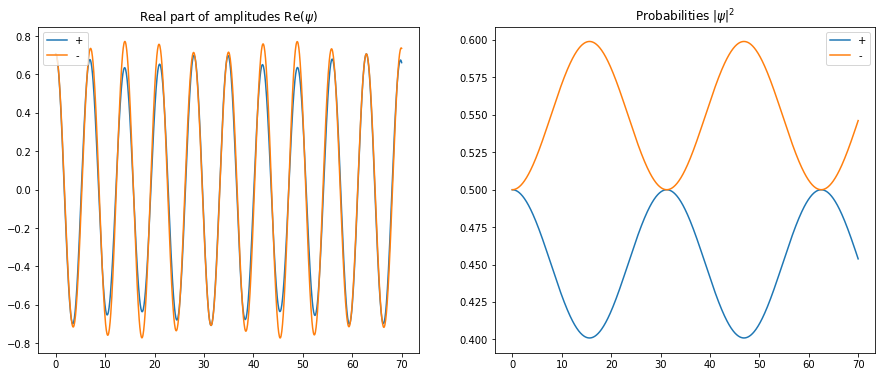

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$", ax=axes[1]);

In phase state $|+> + \,\  |->$  no longer a stationary state. This is not too surprising. We have in effect raised the energy of the plus state and lowered the energy of the minus state so things have changed.

We can see what the true stationary states should be:

In [12]:
H.eigenstates()

(array([0.89950124, 1.10049876]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.67100532]
  [-0.74145253]],
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.74145253]
  [ 0.67100532]]], dtype=object))

The lower energy state is symmetric as before and we have less of the plus state and more of the minus state which creates the lowest energy.

Let's see how the energy of the stationary states changes as the perturbation increases


In [13]:
n_deltas = 50
deltas = delta*np.array(range(0,n_deltas))
upper = np.zeros(n_deltas)
lower = np.zeros(n_deltas)

for i, d in enumerate(deltas):
    H = E0*qeye(2) - A*sigmax() + d*sigmaz()
    E = H.eigenenergies()
    upper[i] = E[1]
    lower[i] = E[0]
Energies = pd.DataFrame(data={"up":upper, "low":lower, "$\delta$/A":deltas/A})

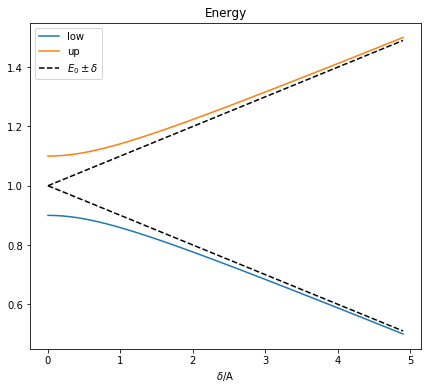

In [14]:
Energies.plot(x="$\delta$/A", title="Energy", figsize=(7,6));
plt.plot((deltas/A),(E0+deltas),'k--')
plt.plot((deltas/A),(E0-deltas),'k--',label="$E_0 \pm \delta$");
plt.legend()

As the perturbation increases, the coupling becomes less and less important. We can see this in the energy which approaches $E_0 \pm \delta$, i.e. no dependence on $A$ at all.

The exact energy takes the form $E_0 \pm \sqrt{A^2 + \delta^2}$ (link out to formal solution for this system)

We will now consider the case when the purturbation is small, i.e $\delta/A \ll 1$. In this case the energies are approximately

$$
E_I = E_0 + A +\frac{\delta^2}{2A} \\
E_{II} = E_0 - A -\frac{\delta^2}{2A}
$$

As a side note, one might hope to be able to calcualte the above approximate energies using [first order perturbation theory](https://en.wikipedia.org/wiki/Perturbation_theory_(quantum_mechanics)#First_order_corrections) (see also more compact explanation [here](https://math.stackexchange.com/a/626736)), but the $\delta^2$ tells you this isn't possible.

You can explicity see this by using QuTip to calculate the [matrix element](http://qutip.org/docs/latest/guide/guide-basics.html?highlight=matrix%20element#functions-operating-on-qobj-class) between the perturbation $\delta\sigma_z$ and the unperturbed eigenvectors.


In [15]:
delta*sigmaz().matrix_element(in_phase,in_phase)

0j

## 2.2 Time dependent perturbation

Now let's consider a tiem dependent perturbation of the form $\delta\cos(\omega t)$. With QuTiP, we can add [time dependence in several ways](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html#function-based-time-dependence)

### Off resonance

In [16]:
E0 = 1.0
delta = 0.01
A = 0.1

H0 = E0*qeye(2) - A*sigmax() 

H1 =  delta*sigmaz()

H = [H0,[H1,'cos(0.25*t)']]

times = np.linspace(0.0, 700.0, 1000) 

result = sesolve(H, in_phase, times)
df =  states_to_df(result.states, times)


/home/matt/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


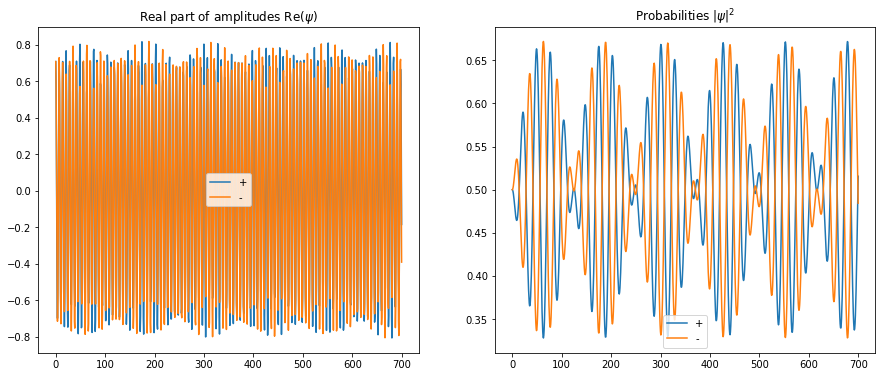

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$", ax=axes[1]);

Changing basis helps us see what's going on more easily.

In [18]:
def change_basis_to_df(states, times, new_basis, new_basis_labels):
    psi_new_basis_0 = np.zeros(len(times),dtype="complex128")  # To store the amplitude of the new_basis_0 state
    psi_new_basis_1 = np.zeros(len(times),dtype="complex128") # To store the amplitude of the new_basis_0 state

    for i, state in enumerate(states):
        transformed_state = state.transform(new_basis)
        psi_new_basis_0[i] = transformed_state[0][0][0]
        psi_new_basis_1[i] = transformed_state[1][0][0]

    return pd.DataFrame(data={new_basis_labels[0]:psi_new_basis_0, new_basis_labels[1]:psi_new_basis_1}, index=times)

In [19]:
df = change_basis_to_df(result.states, times, [in_phase,out_phase], ["in_phase", "out_phase"])

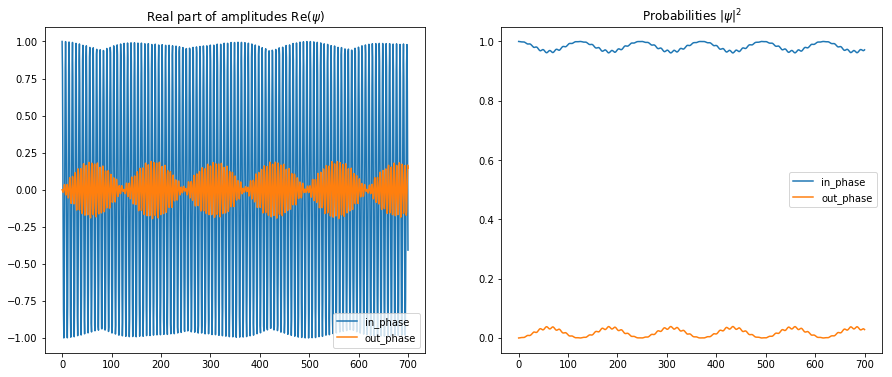

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$", ax=axes[1]);

### Resonance

In [23]:
E0 = 1.0
delta = 0.01
A = 0.1

H0 = E0*qeye(2) - A*sigmax() 

H1 =  delta*sigmaz()

H = [H0,[H1,'cos(0.2*t)']]

times = np.linspace(0.0, 700.0, 1000) 

result = sesolve(H, in_phase, times)
df =  states_to_df(result.states, times)


In [24]:
df = change_basis_to_df(result.states, times, [in_phase,out_phase], ["in_phase", "out_phase"])

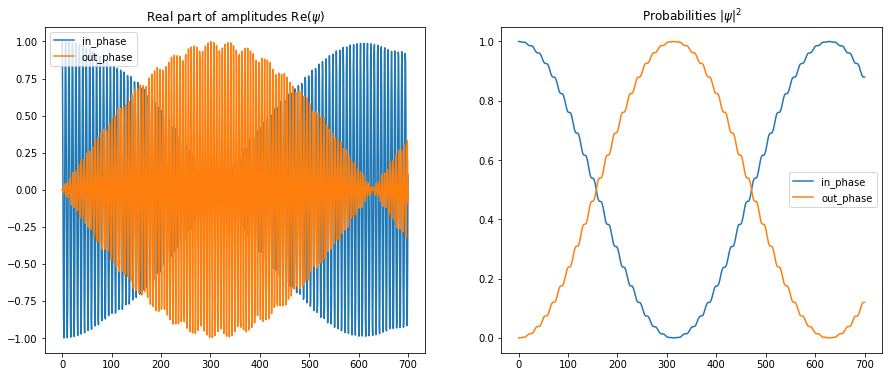

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$", ax=axes[1]);

We can see the period even clearer now, it's determined by the size of $\delta$

$$
T = \frac{2\pi}{\delta} \approx 630
$$